<a href="https://colab.research.google.com/github/davibuss/Bioinformatics/blob/main/PatientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%ls
%cd drive/MyDrive/Bioinformatics/
%ls

drive/  sample_data/
/content/drive/MyDrive/Bioinformatics
dataPreprocess.py  Network.ipynb  PatientNet.ipynb  README.md       Trial.ipynb
Directories.ipynb  organization/  __pycache__/      Training.ipynb


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Bioinformatics')

In [4]:

import os
from os import listdir
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tqdm.notebook import tqdm
import PIL.Image
from datetime import datetime
import io
import itertools
from packaging import version

import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
import pickle
import math
from math import floor
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path

In [5]:
vgg_model = tf.keras.models.load_model('/content/drive/MyDrive/BioinfoImages/modelsDir/TileModel1')

In [45]:
path = '/content/drive/MyDrive/meso_san_luigi/M-103.ndpi'
path2 = '/content/drive/MyDrive/meso_san_luigi/M-102.ndpi'

In [ ]:
!pip install --upgrade setuptools pip
!pip install openslides

!apt update && apt install -y openslide-tools
!pip install openslide-python

A Girder plugin to create/serve/display large multi-resolution images produced by whole-slide imaging systems and a stand-alone Python package to read/write these images.

In [ ]:
! pip install histomicstk --find-links https://girder.github.io/large_image_wheels

In [13]:
import large_image
from openslide import OpenSlide

In [31]:
import large_image_source_openslide

Created LRU Cache for 'tilesource' with 67 maximum size


In [46]:
large_image_source_openslide.canRead(path)
source = large_image_source_openslide.open(path2)

In [47]:
source.getTileCount()

42427

In [42]:
ts = large_image.getTileSource(path)

In [188]:
ts.getNativeMagnification()

{'magnification': 20.0,
 'mm_x': 0.00044152059693584704,
 'mm_y': 0.00044152059693584704}

In [209]:
ts.levels-1

8

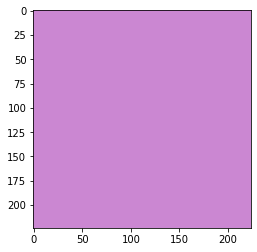

In [222]:
mag = (20.0)*(224)
ix,iy = (mag*4,mag*4)
tile_info = ts.getSingleTile(
        tile_size=dict(width=224, height=224),
        scale=dict(magnification=mag),
        tile_position={'level_x':ix ,'level_y':iy},
        tiffCompresion = 'raw'
    )
plt.imshow(tile_info['tile'])

In [193]:
x,y = (0,0)
xm , ym = (5,5)

mag = 20
ix,iy = (mag*4,mag*4)

fig = plt.figure(figsize=(50,50))

for x in range(xm):
  for y in range(ym):
    tile_info = ts.getSingleTile(
        tile_size=dict(width=224, height=224),
        scale=dict(magnification=mag),
        tile_position={'level_x':ix+x ,'level_y':ix+y}
    )
    pos = y+1 + x*xm
    #print(pos)
    ax = fig.add_subplot(xm,ym,pos)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'x:{x},y:{y}')
    plt.imshow(tile_info['tile'])

plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import tqdm

In [82]:
print(ts.sizeX)
print(ts.sizeY)

30720
35200


In [83]:
num_tiles = 0

tile_means = []
tile_areas = []

for tile_info in tqdm(ts.tileIterator(
    region=dict(left=0, top=0, width=ts.sizeX, height=ts.sizeY, units='base_pixels'),
    scale=dict(magnification=0),
    tile_size=dict(width=224, height=224),
    format=large_image.tilesource.TILE_FORMAT_PIL
)):

    if num_tiles == 100:
        print('Tile-{} = '.format(num_tiles))
        display(tile_info)

    im_tile = np.array(tile_info['tile'])
    tile_mean_rgb = np.mean(im_tile[:, :, :3], axis=(0, 1))

    tile_means.append( tile_mean_rgb )
    tile_areas.append( tile_info['width'] * tile_info['height'] )

    num_tiles += 1

slide_mean_rgb = np.average(tile_means, axis=0, weights=tile_areas)

print('Number of tiles = {}'.format(num_tiles))
print('Slide mean color = {}'.format(slide_mean_rgb))

Tile-100 = 


{'format': 'PIL',
 'gheight': 224.0,
 'gwidth': 224.0,
 'gx': 22400.0,
 'gy': 0.0,
 'height': 224,
 'iterator_range': {'level_x_max': 138,
  'level_x_min': 0,
  'level_y_max': 158,
  'level_y_min': 0,
  'position': 21804,
  'region_x_max': 138,
  'region_y_max': 158},
 'level': 8,
 'level_x': 100,
 'level_y': 0,
 'magnification': 20.0,
 'mm_x': 0.00044152059693584704,
 'mm_y': 0.00044152059693584704,
 'tile': <PIL.Image.Image image mode=RGBA size=224x224 at 0x7FF89EEB5B90>,
 'tile_overlap': {'bottom': 0, 'left': 0, 'right': 0, 'top': 0},
 'tile_position': {'level_x': 100,
  'level_y': 0,
  'position': 100,
  'region_x': 100,
  'region_y': 0},
 'width': 224,
 'x': 22400,
 'y': 0}


Number of tiles = 21804
Slide mean color = [233.76502115 222.05351878 222.48748036]
